## Results Mortality


In [ ]:
import numpy as np
import pandas as pd
#from pandas import DataFrame
import matplotlib.pyplot as plt
import matplotlib.colors as colors

%matplotlib inline
import pickle
import palettable
from scipy.sparse import csr_matrix, vstack
from scipy.optimize import curve_fit
import sys 
from netCDF4 import num2date, date2num
import xarray as xr
from netCDF4 import Dataset

import xarray

sys.path.append('../../')

from climada.engine import Impact
from climada.entity import Exposures

from climada.hazard import Hazard
from src.impact_calculation.impact_heat import *
from src.util.plots import *


from scipy.sparse import coo_matrix, vstack

fig_dir = '../../data_analysis/figures/'

In [44]:
directory_exposures = '../../input_data/exposures/'
exposures = {}
for code, category in {'O': 'Over 75', 'U': 'Under 75'}.items():    
    exposures_file = ''.join([directory_exposures, 'exposures_mortality_ch_', code,'2.h5'])
    exposures[category] = Exposures()
    exposures[category].read_hdf5(exposures_file)
    exposures[category].gdf['value'] = exposures[category].gdf['value']*exposures[category].gdf['total_population_canton']
    #exposures[category] = Exposures(exposures[category])
    exposures[category].check()


2022-07-05 11:49:03,635 - climada.entity.exposures.base - WARNING - The use of Exposures.read_hdf5 is deprecated.Use Exposures.from_hdf5 instead.
2022-07-05 11:49:15,504 - climada.entity.exposures.base - WARNING - The use of Exposures.read_hdf5 is deprecated.Use Exposures.from_hdf5 instead.


## Damage cost for each scenario, year and age category

In [15]:
pickle_in = \
open('../../output/mortality_results/impact_CH_values_1000mc_RCP26_RCP45_RCP85_2020_2035_2050.pickle','rb')
impacts_mortality = pickle.load(pickle_in)

pickle_in = \
open('../../output/mortality_results/impact_CH_values_1000mc_RCP26_RCP45_RCP85_2065_2080.pickle','rb')
impacts_mortality_2065_2080 = pickle.load(pickle_in)


In [16]:
impacts_mortality.append_years(impacts_mortality_2065_2080)


In [17]:
for scenario in impacts_mortality.median_impact_matrices:
    for year in impacts_mortality.median_impact_matrices[scenario]:
        impacts_mortality.median_impact_matrices[scenario][year].write

In [ ]:
data = {}
for scenario in impacts_mortality.median_impact_matrices:
    data[scenario] = {}
    for cat in impacts_mortality.median_impact_matrices[scenario][2020]:
        data[scenario][cat] = vstack([impacts_mortality.median_impact_matrices[scenario][y][cat] 
                for y in impacts_mortality.median_impact_matrices[scenario]]).toarray()
    

In [ ]:
impacts_mortality.median_impact_matrices[scenario][2020][cat]

In [ ]:
from matplotlib import cycler
IPython_default = plt.rcParams.copy()
colors = cycler('color',
                       ['#EE6666', '#3388BB', '#9988DD',
                        '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
      axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='blue')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)
plt.rc('font', family='serif')
with plt.style.context('ggplot'):
    plot_impacts_heat(impacts_mortality.agg_impacts_mc, unit='Heat-Related Deaths [#]', impact_type='mortality', color=['darkseagreen', 'darkolivegreen'], labels_cat=['≥ 75 Years','<75 Years'], save=True)



In [ ]:
total_death = (impacts_mortality.agg_impacts_mc['RCP26'][2080]['Over 75'].median()+impacts_mortality.agg_impacts_mc['RCP26'][2080]['Under 75'].median())

In [ ]:
total_death

In [ ]:
1524-701

In [ ]:
823/701

In [ ]:
impacts_mortality.agg_impacts_mc['RCP85'][2080]['Over 75'].median()

In [ ]:
impacts_mortality.agg_impacts_mc['RCP85'][2020]['Over 75'].median()/total_death

In [ ]:
np.median(impacts_mortality.agg_impacts_mc['RCP85'][2080]['Over 75'])+np.median(impacts_mortality.agg_impacts_mc['RCP85'][2080]['Under 75'])-np.median(impacts_mortality.agg_impacts_mc['RCP26'][2080]['Over 75'])-np.median(impacts_mortality.agg_impacts_mc['RCP26'][2080]['Under 75'])


In [ ]:
(np.median(impacts_mortality.agg_impacts_mc['RCP26'][2080]['Over 75'])+np.median(impacts_mortality.agg_impacts_mc['RCP26'][2080]['Under 75']))


In [ ]:
def median_death(scenario, year, category='all'):
    if category=='all':
        median_death = (np.median(impacts_mortality.agg_impacts_mc[scenario][year]['Over 75'])+np.median(impacts_mortality.agg_impacts_mc[scenario][year]['Under 75']))
    else:    
        median_death = np.median(impacts_mortality.agg_impacts_mc[scenario][year][category])
    return median_death

def percentile_death(scenario, year, percentile, category='all'):
    if category=='all':
        median_death = (np.percentile(impacts_mortality.agg_impacts_mc[scenario][year]['Over 75'], percentile)+np.percentile(impacts_mortality.agg_impacts_mc[scenario][year]['Under 75'], percentile))
    else:    
        median_death = np.percentile(impacts_mortality.agg_impacts_mc[scenario][year][category],percentile)
    return median_death

def max_death(scenario, year, category='all'):
    if category=='all':
        median_death = (np.max(impacts_mortality.agg_impacts_mc[scenario][year]['Over 75'])+np.max(impacts_mortality.agg_impacts_mc[scenario][year]['Under 75']))
    else:    
        median_death = np.max(impacts_mortality.agg_impacts_mc[scenario][year][category])
    return median_death

In [ ]:
print(percentile_death('RCP85', 2050, 60, category='all'))
print(percentile_death('RCP85', 2050, 60, category='all'))
print(median_death('RCP85', 2050))

print(median_death('RCP85', 2050) - percentile_death('RCP85', 2050, 90, category='all'))
print(median_death('RCP85', 2050) - percentile_death('RCP85', 2050, 95, category='all'))


In [ ]:
percentile_death('RCP85', 2050, 60, category='all')

## Spatial Impact

In [ ]:
import matplotlib
from climada.util.plot import make_map
import cartopy.crs as ccrs
import matplotlib


exposures['Under 75'].check()
exposures['Under 75'].to_crs(epsg=3785, inplace=True)

exposures['Under 75'].plot_hexbin(pop_name=False, buffer=0.1, norm=matplotlib.colors.LogNorm())
plt.savefig('../figures/map_exposures_ch_u75.pdf',bbox_inches='tight')   


2022-07-05 10:48:58,614 - climada.util.plot - WARNING - Error parsing coordinate system 'EPSG:4326'. Using projection PlateCarree in plot.


<GeoAxesSubplot:>

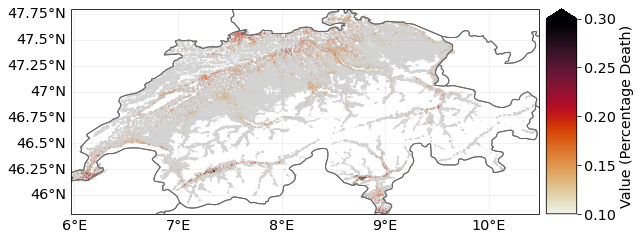

In [21]:
category = 'Over 75'
categories_code = {'Over 75':'O', 'Under 75':'U'}
cm = palettable.cartocolors.sequential.Emrld_7.mpl_colormap

impact = impacts_mortality.matrix_as_impact(impacts_mortality.median_impact_matrices['RCP85'][2050][category], exposures[category], percentage=True, unit='Percentage Death')

impact.plot_hexbin_impact_exposure(pop_name=False, vmin=0.1, vmax=0.3, extend='max')

#plt.savefig(''.join([fig_dir,'spatial_impact_2050_o75.pdf']),bbox_inches='tight')

In [138]:
impact_table['heat_related_death_U75'].sum()+impact_table['heat_related_death_O75'].sum()

695.3484929966945

In [141]:
import copy
import os
for rcp in impacts_mortality.median_impact_matrices:
    for year in impacts_mortality.median_impact_matrices[rcp]:
                impact_o = impacts_mortality.matrix_as_impact(impacts_mortality.median_impact_matrices[rcp][year]['Over 75'], exposures['Over 75'])
                impact_u = impacts_mortality.matrix_as_impact(impacts_mortality.median_impact_matrices[rcp][year]['Under 75'], exposures['Over 75'])


                impact_table = copy.deepcopy(exposures['Over 75'].gdf)

                impact_table['heat_related_death_U75'] = np.array(impact_u._build_exp_event(1).gdf['value'])
                impact_table['heat_related_death_O75'] = np.array(impact_o._build_exp_event(1).gdf['value'])
                impact_table['population_estimate_U75'] = np.array(exposures['Under 75'].gdf['value'])
                impact_table['population_estimate_O75'] = np.array(exposures['Over 75'].gdf['value'])


                impact_table = impact_table[['latitude','longitude','canton', 'heat_related_death_U75','heat_related_death_O75','population_estimate_U75','population_estimate_O75']]
                file_name = "".join(['heat_related_mortality_yearly_average_estimate_',rcp,'_',str(year),'.csv'])
                path = ('/Users/szelie/OneDrive - ETH Zurich/data/heat_related_mortality_productivity_loss')
                impact_table.to_csv(os.path.join(path,file_name))

## Relative change map

In [ ]:
rel_mat = ImpactsHeatMortality.compute_relative_change(impacts_mortality.median_impact_matrices['RCP85'][2050][category], impacts_mortality.median_impact_matrices['RCP85'][2020][category])
impacts_rel = ImpactsHeatMortality.matrix_as_impact(rel_mat, exposures[category], unit='Relative Change [%]')
impacts_rel.plot_hexbin_impact_exposure(pop_name=False, buffer=0.1, vmax=300, extend='max')

plt.savefig(''.join([fig_dir,'relative_changes_2020_2050_o75.pdf']),bbox_inches='tight')

In [ ]:
rel_mat = ImpactsHeatMortality.compute_relative_change(impacts_mortality.median_impact_matrices['RCP26'][2050][category], impacts_mortality.median_impact_matrices['RCP85'][2020][category])
impacts_rel = ImpactsHeatMortality.matrix_as_impact(rel_mat, exposures[category], unit='Relative Change [%]')
impacts_rel.plot_hexbin_impact_exposure(pop_name=False,  buffer=0.1, vmax=100, extend='max')

plt.savefig(''.join([fig_dir,'relative_changes_2020_2050_o75_rcp26.pdf']),bbox_inches='tight')

## Make Table with Cantonal Values

In [ ]:
categories_short = {'Over 75': '≥75', 'Under 75': '<75'}
#cantonal_impacts_df = impacts_mortality.median_impact_matrices['RCP26'][2020]=impacts_mortality.median_impact_matrices['RCP26'][2080]
#cantonal_impacts_df = impacts_mortality.median_impact_matrices['RCP45'][2020]=impacts_mortality.median_impact_matrices['RCP45'][2080]

cantonal_impacts_df = impacts_mortality.cantonal_impacts_df(exposures, scenarios=['RCP26', 'RCP85'], years=[2020,2050,2080], categories_short=categories_short)


In [ ]:
cantonal_impacts_df_rcp45 = impacts_mortality.cantonal_impacts_df(exposures, scenarios=['RCP45'], years=[2020,2050,2080], categories_short=categories_short)


In [ ]:
cantonal_impacts_df_rcp45

In [ ]:
cantonal_impacts_df

In [ ]:
cantonal_impacts_df_total = cantonal_impacts_df.groupby(level=[0,1], axis=1).sum().astype(int)

In [ ]:
cantonal_impacts_df_total

In [ ]:
cantonal_impacts_df_total.insert(0, 'Baseline (2020)', cantonal_impacts_df_total['RCP8.5'][2020])

In [ ]:
cantonal_impacts_df['RCP8.5'][2020]['≥75']/(cantonal_impacts_df['RCP8.5'][2020]['≥75']+cantonal_impacts_df['RCP8.5'][2020]['<75'])
                                                                                                                           

In [ ]:
cantonal_impacts_df

In [ ]:
with pd.option_context("max_colwidth", 1000):
    print(cantonal_impacts_df_total.to_latex(multicolumn=True))


In [ ]:
cantonal_impacts_df_total = cantonal_impacts_df_total.drop(columns=2020,level=1)

In [ ]:
(cantonal_impacts_df_total['RCP8.5'][2080]-cantonal_impacts_df_total['RCP2.6'][2080])

In [ ]:
cantonal_impacts_df_total['RCP2.6'][2080]

In [ ]:
(cantonal_impacts_df_total['RCP8.5'][2080]-cantonal_impacts_df_total['RCP2.6'][2080])/(cantonal_impacts_df_total['RCP2.6'][2080])




In [ ]:
cantonal_impacts_df_total

In [ ]:
with pd.option_context("max_colwidth", 1000):
    print(cantonal_impacts_df_total.to_latex(multicolumn=True))
